In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime, timezone
import pandas as pd
import json
import fitsio
import time
import pickle
import re

%reload_ext autoreload
%autoreload 2

In [2]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.coreRL.offline_dataset import OfflineDELVEDataset
from survey_ops.coreRL.agents import Agent
from survey_ops.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.sys_utils import seed_everything
from survey_ops.coreRL.data_processing import load_raw_data_to_dataframe


In [3]:
from survey_ops.utils import ephemerides
from tqdm import tqdm
from pathlib import Path

In [4]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from collections import Counter
from scipy.stats import entropy

In [5]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

# Load config and lookup files

In [6]:
with open('../configs/global_config.json', 'r') as f:
    gcfg = json.load(f)

In [7]:
with open('../experiment_results/az_grid_config.json', 'r') as f:
    cfg = json.load(f)

In [8]:
# with open(glob_cfg.get('paths.lookup_dir') + '/' + cfg.get('paths')['FIELD2NVISITS'], 'r') as f:
#     field2nvisits = json.load(f)
# with open(glob_cfg.get('paths.lookup_dir') + '/' + cfg.get('paths')['FIELD2NAME'], 'r') as f:
#     field2name = json.load(f)
# with open(glob_cfg.get('paths.lookup_dir') + '/' + cfg.get('paths')['FIELD2RADEC'], 'r') as f:
#     field2radec = json.load(f)
with open('../data/lookups/nside16_bin2azel.json', 'r') as f:
    bin2azel = json.load(f)


In [11]:
# fits_path = Path(cfg.get('paths.DFITS')).resolve().parents[1] / 'data' / cfg.get('paths.DFITS')
# json_path = Path(cfg.get('paths.DJSON')).resolve().parents[1] / 'data' / cfg.get('paths.DJSON')

df = load_raw_data_to_dataframe(fits_path='../data/fits/decam-exposures-20251211.fits')

cfg['data']['specific_years'] = [2019]
cfg['data']['specific_months'] = None
cfg['data']['specific_days'] = None
cfg['data']['include_bin_features'] = True

In [13]:
with open('../experiment_results/bc-azel-4years/evaluation_1/eval_metrics.pkl', 'rb') as f:
    eval_metrics = pickle.load(f)

In [15]:
eval_metrics['ep-0']

{'glob_observations': {'night-0': array([[ 1.11180274e-02,  9.99938190e-01, -3.35198998e-01,
           1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
           1.00000000e+00,  1.00000000e+00,  0.00000000e+00,
           3.43662709e-01, -9.39093173e-01, -2.46087492e-01,
          -9.17650223e-01, -3.97389024e-01, -3.77983212e-01,
           8.13915908e-01, -5.80982745e-01, -1.75111100e-01,
          -5.42043507e-01, -8.40350449e-01, -2.20486626e-01,
           7.88103882e-03,  9.99968946e-01,  0.00000000e+00,
           3.35853964e-01],
         [ 7.29600072e-01,  6.83874071e-01, -2.87736416e-01,
          -1.00740902e-01, -9.94912684e-01,  5.42628348e-01,
           7.52834976e-01,  6.85880363e-01,  7.27714300e-01,
           3.43687832e-01, -9.39083934e-01, -2.46085331e-01,
          -9.21220064e-01, -3.89041871e-01, -3.79873306e-01,
           8.14123929e-01, -5.80691159e-01, -1.75050229e-01,
          -5.46724141e-01, -8.37312818e-01, -2.24401534e-01,
           9.68878150e-01

In [10]:
d = OfflineDELVEDataset(
    df=df,
    cfg=cfg,
    gcfg=gcfg,
    )

Calculating sun and moon ra/dec and az/el: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 247/247 [00:00<00:00, 1214.28it/s]
Calculating bin features for all healpix bins and timestamps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 247/247 [00:01<00:00, 199.76it/s]


In [12]:
d.next_state_idxs

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 102, 103, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 18

In [13]:
val_nights = np.random.choice(d.unique_nights, size=2, replace=False)
transition_nights = d._df.iloc[d.next_state_idxs - 1]['night'].values

In [17]:
np.isin(transition_nights, val_nights)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [19]:
from torch.utils.data import Subset

In [20]:
Subset(d,[0])

In [ ]:
def get_dataloader(self, batch_size, num_workers, pin_memory, random_seed, drop_last=True, val_split=.1, return_train_and_val=True):
        generator = torch.Generator().manual_seed(random_seed)
        np.random.seed(random_seed) # Ensure consistent night selection
        
        # 1. Randomly sample whole nights for the validation set
        num_val_nights = max(1, int(self.n_nights * val_split))
        val_nights = np.random.choice(self.unique_nights, size=num_val_nights, replace=False)
        
        # 2. Track which night each transition belongs to
        # We must handle the two different ways states are constructed
        if hasattr(self, 'next_state_idxs') and self.next_state_idxs is not None:
            # When remove_large_time_diffs is True
            transition_nights = self._df.iloc[self.next_state_idxs - 1]['night'].values
        else:
            # When remove_large_time_diffs is False
            transition_nights = self._df.groupby('night')['night'].apply(lambda x: x.iloc[:-1]).values
            
        # 3. Create boolean mask mapping transitions to the selected val nights
        val_mask = np.isin(transition_nights, val_nights)
        
        # 4. Extract the exact indices for train and val subsets
        train_indices = np.where(~val_mask)[0].tolist()
        val_indices = np.where(val_mask)[0].tolist()
        
        # 5. Create Subsets
        train_dataset = Subset(self, train_indices)
        val_dataset = Subset(self, val_indices)
        
        # Train loader (sampled with replacement for continuous streaming)
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            sampler=RandomSampler(train_dataset, replacement=True, num_samples=10**10, generator=generator),
            drop_last=drop_last,
            num_workers=num_workers,
            pin_memory=pin_memory
        )
        
        if return_train_and_val:
            # Val loader (sequential evaluation, no shuffling)
            val_loader = DataLoader(
                val_dataset,
                batch_size=batch_size,
                shuffle=False, 
                drop_last=False,
                num_workers=num_workers,
                pin_memory=pin_memory,
            )
            return train_loader, val_loader
            
        import warnings
        warnings.warn("Only train loader returned. Set return_train_and_val=True for validation.", DeprecationWarning)
        return train_loader

In [ ]:
        np.random.seed(random_seed) # Ensure consistent night selection
        
        # 1. Randomly sample whole nights for the validation set
        num_val_nights = int(self.n_nights * val_split)
        val_nights = np.random.choice(self.unique_nights, size=num_val_nights, replace=False)
        
        # 2. Create boolean mask mapping transitions to the selected val nights
        val_mask = np.isin(self.transition_nights, val_nights)
        
        # 3. Extract the exact indices for train and val
        train_indices = np.where(~val_mask)[0].tolist()
        val_indices = np.where(val_mask)[0].tolist()
        
        # 4. Create Subsets
        train_dataset = Subset(self, train_indices)
        val_dataset = Subset(self, val_indices)
        
        # Train loader

In [49]:
from survey_ops.coreRL.data_processing import *

In [50]:
objects_to_remove = ["guide", "DES vvds","J0'","gwh","DESGW","Alhambra-8","cosmos","COSMOS hex","TMO","LDS","WD0","DES supernova hex","NGC","ec", "(outlier)"]

In [51]:
# Process dataframe to add columns for global features
df['night'] = (df['datetime'] - pd.Timedelta(hours=12)).dt.normalize()
df = drop_rows_in_DECam_data(df, objects_to_remove=objects_to_remove)
df = remove_dates(df,
                  specific_years=cfg['data']['specific_years'], 
                  specific_months=cfg['data']['specific_months'], 
                  specific_days=cfg['data']['specific_days'],
                  specific_filters=cfg['data']['specific_filters']
                  )

TypeError: only list-like objects are allowed to be passed to isin(), you passed a `int`

In [ ]:
hpGrid = ephemerides.HealpixGrid(nside=cfg['data']['nside'], is_azel=True)
bin_features = {}
pointing_features = {}

In [ ]:
# calculated_features['moon_distance'] = np.empty(shape=(len(df), len(hpGrid.idx_lookup)), dtype=np.float32)
pointing_features['moon_distance']
ra_arr = df['ra'].values
dec_arr = df['dec'].values

for i, time in enumerate(df['timestamp'].values):
    pointing_lon, pointing_lat = ra_arr[i], dec_arr[i]
    moon_lon, moon_lat = get_source_ra_dec(source='moon', time=time, observer=observer)
    if hpGrid.is_azel:
        moon_lon, moon_lat = equatorial_to_topographic(
            ra=moon_lon, dec=moon_lat, time=time
        )
        pointing_lon, pointing_lat = equatorial_to_topographic(
            ra=pointing_lon, dec=pointing_lat, time=time
        )
    


In [43]:
calculated_features['moon_distance'].shape

(82345, 1504)

In [45]:
df['filter'].values

array(['g', 'g', 'g', ..., 'g', 'i', 'g'], shape=(82345,), dtype=object)

(array([19117.,     0., 17196.,     0.,     0., 15961.,     0., 15565.,
            0., 14506.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

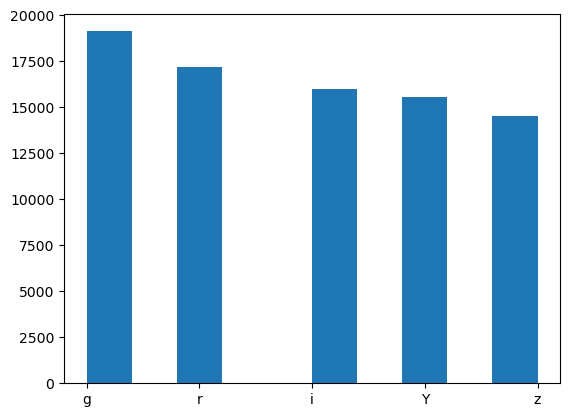

In [44]:
plt.hist(df['filter'].values)

In [16]:
df.columns

Index(['expnum', 'ra', 'dec', 'exptime', 'filter', 'propid', 'program',
       'object', 'teff', 'fwhm', 'datetime', 'az', 'zd', 'ha', 'airmass',
       'qc_fwhm', 'qc_cloud', 'qc_sky', 'qc_teff', 'timestamp'],
      dtype='object')

In [19]:
df['filter'].unique()

array(['g', 'r', 'i', 'Y', 'z'], dtype=object)

In [20]:
FILTER2TOKEN = {str(k): tok for tok, k in enumerate(df['filter'].unique())}

In [21]:
FILTER2TOKEN

{'g': 0, 'r': 1, 'i': 2, 'Y': 3, 'z': 4}

In [25]:
df.columns

Index(['expnum', 'ra', 'dec', 'exptime', 'filter', 'propid', 'program',
       'object', 'teff', 'fwhm', 'datetime', 'az', 'zd', 'ha', 'airmass',
       'qc_fwhm', 'qc_cloud', 'qc_sky', 'qc_teff', 'timestamp'],
      dtype='object')

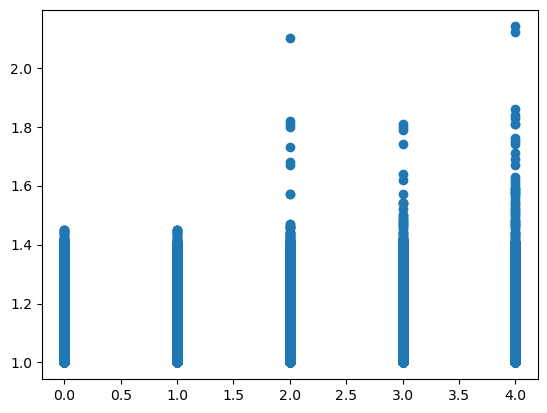

In [26]:
plt.scatter(df['filter'].map(FILTER2TOKEN).values, df['airmass'])

In [ ]:
plt.scatter(df['filter'].ma,)

In [10]:
dat_fn = './full_azel_offline_dataset.pkl'

In [ ]:
try:
    with open(dat_fn, 'rb') as f:
        d = pickle.load(f)
except:
    d = OfflineDELVEDataset(
        df=df,
        cfg=cfg,
        gcfg=gcfg,
        )
    with open(dat_fn, 'wb') as f:
        pickle.dump(d, f)

# Action distribution

## azel

### Histograms: Bin history overall, by year, by month

In [ ]:
# Count bins with < 100 examples
d_actions = d.actions.detach().numpy()
unique_bin_ids, bin_counts = np.unique(d_actions, return_counts=True)
rare_bins = sum(1 for count in bin_counts if count < 50)
print(f"Bins with <50 examples: {rare_bins}/{d.num_actions}={rare_bins / d.num_actions}")

In [ ]:
plt.hist(unique_bin_ids, bins=50);
plt.title('Bins visited (azel)')
plt.xlabel('bin id')
plt.savefig('dataset-wide-plots/azel/expert_bins_visited_histogram.png')


In [ ]:
print('Fraction of all bins that equal next bin', np.count_nonzero(d._df['bin'][:-1].values == d._df['bin'][1:].values) / len(d._df['bin']))
print('Fraction of bins visited in entire dataset', len(unique_bin_ids)/d.num_actions)


In [ ]:
years = d._df['datetime'].dt.year.unique()
for year in years:
    _actions = d._df['bin'][d._df['datetime'].dt.year == year].values
    plt.hist(_actions, histtype='step', label=year, lw=3, density=True)
plt.legend()
plt.xlabel('Bin id')
plt.savefig('dataset-wide-plots/azel/expert_bins_visited_histogram_split_years.png')

In [ ]:
months = d._df['datetime'].dt.month.unique()

for month in months:
    _actions = d._df['bin'][d._df['datetime'].dt.month == month].values
    plt.hist(_actions, histtype='step', label= 'month ' + str(month), lw=3, density=True)
plt.legend()
plt.xlabel('Bin id')
plt.savefig('dataset-wide-plots/azel/expert_bins_visited_histogram_split_months.png')

In [ ]:
for i, (night, group) in enumerate(d._df.groupby('night')):
    if group['datetime'].dt.year.values[0] == 2013:
        continue
    tstart = group['timestamp'].min()
    time_since_start = (group['timestamp'].values - tstart)/3600
    plt.plot(time_since_start[:-1], np.diff(group['field_id'].values.astype(np.int32)), marker='o')
    plt.title(night)
    plt.xlabel('hours')
    plt.show()
    break


In [ ]:
step = 1
num_same_visit_twice = np.count_nonzero(d._df['field_id'].values.astype(np.int32)[:-1:step] == d._df['field_id'].values.astype(np.int32)[1::step])
num_same_visit_thrice = np.count_nonzero(d._df['field_id'].values.astype(np.int32)[:-2:step] == d._df['field_id'].values.astype(np.int32)[2::step])
num_same_visit_four = np.count_nonzero(d._df['field_id'].values.astype(np.int32)[:-3:step] == d._df['field_id'].values.astype(np.int32)[3::step])


In [ ]:
print(f"Field is visited 2x consecutively {100*num_same_visit_twice/len(d):.2f}% of the time")
print(f"Field is visited 3x consecutively {100*num_same_visit_thrice/len(d):.2f}% of the time")
print(f"Field is visited 4x consecutively {100*num_same_visit_four/len(d):.2f}% of the time")

All special fields are probably removed

### Bins visited scatter plots (azel)

In [ ]:
visited_bins_azels = np.array([bin2azel[str(bid)] for bid in d_actions])

In [ ]:
plt.scatter(visited_bins_azels[:, 0]/units.deg, visited_bins_azels[:, 1]/units.deg, alpha=.05)
plt.xlabel('az (deg)')
plt.ylabel('el (deg)')
plt.savefig('dataset-wide-plots/azel/expert_bins_visited_scatter_sky.png')

In [ ]:
c = plt.scatter(d.hpGrid.lon/units.deg, d.hpGrid.lat/units.deg, c=np.arange(len(d.hpGrid.lat)))
plt.colorbar(c)
plt.xlabel('az (deg)')
plt.ylabel('el (deg)')
plt.savefig('dataset-wide-plots/azel/healpixbins_scattered_colored_by_id.png')

In [ ]:
c = plt.scatter(d.hpGrid.lon/units.deg, d.hpGrid.lat/units.deg, color='grey', label='grid')
c = plt.scatter(d.hpGrid.lon[:500]/units.deg, d.hpGrid.lat[:500]/units.deg, c=np.arange(len(d.hpGrid.lat[:500])), label='bins typically visited by agent')
plt.scatter(d.hpGrid.lon[250]/units.deg, d.hpGrid.lat[250]/units.deg, color='black', label='mean bin chosen by agent')
plt.legend()
plt.colorbar(c)
plt.xlabel('az (deg)')
plt.ylabel('el (deg)')
plt.savefig('dataset-wide-plots/azel/healpixbins_scattered_colored_by_id.png')

In [ ]:
# Angular spearation between consecutive observed bins
pos1 = visited_bins_azels[:-1, :].T
pos2 = visited_bins_azels[1:, :].T
visited_bins_ang_seps = geometry.angular_separation(pos1, pos2)

In [ ]:
# Mean healpix angular separation
lonlat = np.array((d.hpGrid.lon, d.hpGrid.lat))
pos1 = lonlat[:, :-1]
pos2 = lonlat[:, 1:]
ang_seps = geometry.angular_separation(pos1=pos1, pos2=pos2)
mean_healpix_ang_sep = ang_seps.mean()

In [ ]:
plt.hist(visited_bins_ang_seps/units.deg, bins=50, density=True)
plt.vlines(x=mean_healpix_ang_sep/units.deg, ymin=0, ymax=.24, color='black', linestyle='dashed', label=f'mean healpix sep={mean_healpix_ang_sep/units.deg:.2f}')
plt.legend()
plt.xlabel('angular separations (deg)')

### Coverage Analysis

In [ ]:
import seaborn as sns

In [ ]:
d.states.shape

In [ ]:
d_corr = d._df.corr(numeric_only=True)
sns.heatmap(ae_corr, annot=False, cmap='coolwarm')

In [ ]:
sns.heatmap(d_corr[ae_corr > .7], annot=False, cmap='coolwarm')

### Histograms: Bin history overall, by year, by month

In [ ]:
# Count bins with < 100 examples
rd_actions = rd_dat.actions.detach().numpy()
unique_bin_ids, bin_counts = np.unique(rd_actions, return_counts=True)
rare_bins = sum(1 for count in bin_counts if count < 50)
print(f"Bins with <50 examples: {rare_bins}/{d.num_actions}={rare_bins / rd_dat.num_actions}")

In [ ]:
plt.hist(unique_bin_ids, bins=30);
plt.title('Bins visited (radec)')
plt.xlabel('bin id')
plt.savefig('dataset-wide-plots/radec/expert_bins_visited_histogram.png')


In [ ]:
print('Fraction of all bins that equal next bin', np.count_nonzero(rd_dat._df['bin'][:-1].values == rd_dat._df['bin'][1:].values) / len(rd_dat._df['bin']))
print('Fraction of bins visited in entire dataset', len(unique_bin_ids)/rd_dat.num_actions)


In [ ]:
years = rd_dat._df['datetime'].dt.year.unique()
for year in years:
    _actions = rd_dat._df['bin'][rd_dat._df['datetime'].dt.year == year].values
    plt.hist(_actions, histtype='step', label=year, lw=3, density=True)
plt.legend()
plt.xlabel('Bin id')
plt.savefig('dataset-wide-plots/radec/expert_bins_visited_histogram_split_years.png')

In [ ]:
months = np.sort(rd_dat._df['datetime'].dt.month.unique())
for month in months:
    _actions = rd_dat._df['bin'][rd_dat._df['datetime'].dt.month == month].values
    plt.hist(_actions, histtype='step', label= 'month ' + str(month), lw=3, density=True)
plt.legend()
plt.xlabel('Bin id')
plt.savefig('dataset-wide-plots/azel/expert_bins_visited_histogram_split_months.png')

In [ ]:
step = 1
num_same_visit_twice = np.count_nonzero(rd_dat._df['field_id'].values.astype(np.int32)[:-1:step] == rd_dat._df['field_id'].values.astype(np.int32)[1::step])
num_same_visit_thrice = np.count_nonzero(rd_dat._df['field_id'].values.astype(np.int32)[:-2:step] == rd_dat._df['field_id'].values.astype(np.int32)[2::step])

In [ ]:
print(f"Field is visited twice in a row {num_same_visit_twice/len(d):.2f}% of the time")
print(f"Field is visited twice in a row {num_same_visit_thrice/len(d):.2f}% of the time")


In [ ]:
_bin_radecs_actually_visited = np.array([bin2radec[str(bid)] for bid in unique_bin_ids])
c = plt.scatter(rd_dat.hpGrid.lon/units.deg, rd_dat.hpGrid.lat/units.deg, c=np.arange(len(rd_dat.hpGrid.lat)))
plt.scatter(_bin_radecs_actually_visited[:, 0]/units.deg, _bin_radecs_actually_visited[:, 1]/units.deg)
plt.colorbar(c)
plt.xlabel('az (deg)')
plt.ylabel('el (deg)')
plt.savefig('dataset-wide-plots/radec/healpixbins_scattered_colored_by_id.png')

### Action vs state

In [ ]:
dataset.next_states

In [ ]:
alg = BehaviorCloning(obs_dim=dataset.obs_dim, num_actions=dataset.num_actions, hidden_dim=1024, loss_fxn="cross_entropy")
policy_net = alg.load('../experiment_results/bc-azel-best/best_weights.pt')

In [ ]:
plt.hist(dataset._df['bin'].values)

In [ ]:
from survey_ops.algorithms import setup_algorithm

In [ ]:
hpGrid = ephemerides.HealpixGrid(nside=16, is_azel=True)

In [ ]:
algorithm = setup_algorithm(save_dir='./', algorithm_name=cfg['model']['algorithm'], 
                            obs_dim=cfg['data']['obs_dim'], num_actions=cfg['data']['num_actions'], loss_fxn=cfg['model']['loss_function'],
                            hidden_dim=cfg['train']['hidden_dim'], lr=cfg['train']['lr'], lr_scheduler=cfg['train']['lr_scheduler'], 
                            device=device, lr_scheduler_kwargs=cfg['train']['lr_scheduler_kwargs'], lr_scheduler_epoch_start=cfg['train']['lr_scheduler_epoch_start'], 
                            lr_scheduler_num_epochs=cfg['train']['lr_scheduler_num_epochs'], gamma=cfg['model']['gamma'], 
                            tau=cfg['model']['tau'], activation=cfg['model']['activation'])

agent = Agent(
    algorithm=algorithm,
    train_outdir=cfg['metadata']['outdir'],
)
agent.load(cfg['metadata']['outdir'] + '/best_weights.pt')

In [ ]:
# Plot predicted action for each state
with torch.no_grad():
    logits = agent.algorithm.policy_net(dataset.states.to(device))
    eval_actions = torch.argmax(logits, dim=1).to('cpu').detach().numpy()

    print(f"Logit stats: min={logits.min():.3f}, max={logits.max():.3f}, std={logits.std():.3f}")
    print(f"Top 5 logits: {logits.topk(5).values}")
    print(f"Top 5 bins: {logits.topk(5).indices}")

In [ ]:
plt.plot(logits.topk(5).values.mean(axis=1).cpu().detach().numpy())

In [ ]:
radec = np.array((df['ra'].values, df['dec'].values))*units.deg
pos1 = radec[:, :-1]
pos2 = radec[:, 1:]
ang_seps = geometry.angular_separation(pos1=pos1, pos2=pos2)
plt.scatter(df['timestamp'].values[1:], ang_seps/units.deg, s=1)
plt.hlines(y=.14/units.deg, xmin=np.min(df['timestamp']), xmax=np.max(df['timestamp']), color='black')

In [ ]:
len(ang_seps[ang_seps < .04]) / len(ang_seps)

In [ ]:
.075 / units.deg

In [ ]:
np.mean(ang_seps)

In [ ]:
for i, feat_name in enumerate(d.state_feature_names):
    feature_row = d.states.T[i].detach().numpy()
    fig, ax = plt.subplots()
    ax.scatter(feature_row, d.actions, c=np.arange(len(feature_row)), label='chrononologically sorted')
    ax.set_title(f'Action vs normalized {feat_name}', fontsize=16)
    fig.savefig(f'./dataset-wide-plots/azel/expert_actions_vs_normalized_{feat_name}_scatter.png')

# Model evaluations

In [ ]:
results_outdir = Path('../experiment_results/bc-azel-2015-2018/')
with open(results_outdir / 'train_metrics.pkl', 'rb') as f:
    train_metrics = pickle.load(f)
with open(results_outdir / 'val_metrics.pkl', 'rb') as f:
    val_metrics = pickle.load(f)
with open(results_outdir / 'val_train_metrics.pkl', 'rb') as f:
    val_train_metrics = pickle.load(f)
with open(results_outdir / 'config.json', 'r') as f:
    train_cfg = json.load(f)

In [ ]:
train_dataset = OfflineDECamDataset(
    df=df,
    cfg=train_cfg,
    glob_cfg=glob_cfg
    )

In [ ]:
trainloader, valloader = train_dataset.get_dataloader(1024, num_workers=train_cfg['train']['num_workers'], pin_memory=True if device.type == 'cuda' else False, random_seed=train_cfg['metadata']['seed'], return_train_and_val=True)


In [ ]:
plt.hist(train_dataset.next_states[:, 0].detach().numpy())

In [ ]:
train_states = train_dataset.next_states[trainloader.dataset.indices]
val_states = train_dataset.next_states[valloader.dataset.indices]


In [ ]:
# Plot train and val loss
fig, axs = plt.subplots(3, sharex=True, figsize=(4, 7))

axs[0].plot(train_metrics['epoch'], train_metrics['train_loss'], label='train', color='black', linestyle='dotted')
axs[0].plot(val_metrics['epoch'], val_metrics['val_loss'], label='val')
axs[0].hlines(y=0, xmin=0, xmax=np.max(val_metrics['epoch']), color='red', linestyle='dashed')
axs[0].set_ylabel('Loss', fontsize=14)
axs[0].legend(fontsize=14)

axs[1].plot(val_train_metrics['epoch'], val_train_metrics['accuracy'], label='train', color='black', linestyle='dotted')
axs[1].plot(val_metrics['epoch'], val_metrics['accuracy'], label='val')
axs[1].hlines(y=1, xmin=0, xmax=np.max(train_metrics['epoch']), color='red', linestyle='dashed')
axs[1].set_ylabel('Accuracy', fontsize=14)
# axs[1].legend()

axs[2].plot(val_train_metrics['epoch'], np.array(val_train_metrics['ang_sep'])/units.deg, label='train', color='black', linestyle='dotted')
axs[2].plot(val_metrics['epoch'], np.array(val_metrics['ang_sep'])/units.deg, label='val')
axs[2].set_ylabel('Angular separation (deg)', fontsize=14)
axs[2].set_xlabel('Epoch', fontsize=14)
axs[2].hlines(y=average_bin_sep/units.deg, xmin=0, xmax=np.max(val_train_metrics['epoch']), label=f'ave bin sep {average_bin_sep/units.deg:.1f} deg', color='red', linestyle='dashed')
axs[2].legend(fontsize=14)
for ax in axs:
    ax.grid(True, alpha=.5)
fig.tight_layout()

In [ ]:
from survey_ops.algorithms.factory import setup_algorithm

In [ ]:
algorithm = setup_algorithm(save_dir='./', algorithm_name=train_cfg['model']['algorithm'], 
                            obs_dim=train_cfg['data']['obs_dim'], num_actions=train_cfg['data']['num_actions'], loss_fxn=train_cfg['model']['loss_function'],
                            hidden_dim=train_cfg['train']['hidden_dim'], lr=train_cfg['train']['lr'], lr_scheduler=train_cfg['train']['lr_scheduler'], 
                            device=device, lr_scheduler_kwargs=train_cfg['train']['lr_scheduler_kwargs'], lr_scheduler_epoch_start=train_cfg['train']['lr_scheduler_epoch_start'], 
                            lr_scheduler_num_epochs=train_cfg['train']['lr_scheduler_num_epochs'], gamma=train_cfg['model']['gamma'], 
                            tau=train_cfg['model']['tau'], activation=train_cfg['model']['activation'])

agent = Agent(
    algorithm=algorithm,
    train_outdir=train_cfg['metadata']['outdir'],
)
agent.load(train_cfg['metadata']['outdir'] + '/best_weights.pt')

In [ ]:
import astroplan

In [ ]:
# Plot predicted action for each state
with torch.no_grad():
    logits = agent.algorithm.policy_net(d.states.to(device))
    eval_actions = torch.argmax(logits, dim=1).to('cpu').detach().numpy()

    print(f"Logit stats: min={logits.min():.3f}, max={logits.max():.3f}, std={logits.std():.3f}")
    print(f"Top 5 logits: {logits.topk(5).values}")
    print(f"Top 5 bins: {logits.topk(5).indices}")

In [ ]:
el, c = np.unique(d.actions, return_counts=True)
train_el, train_c = np.unique(train_dataset.actions, return_counts=True)
el_agent, c_agent = np.unique(eval_actions, return_counts=True)

In [ ]:
sort = np.argsort(c)[::-1]
sort_agent = np.argsort(c_agent)[::-1]
sort_train = np.argsort(train_c)[::-1]


In [ ]:
c = c[sort]
el = el[sort]
c_agent = c_agent[sort_agent]
el_agent = el[sort_agent]
c_train = train_c[sort_train]
el_train = train_el[sort_train]

In [ ]:
plt.plot(c_agent)
plt.plot(c_train)
plt.plot(c)

In [ ]:
len(np.unique(el_train)) / len(d.hpGrid.lon)

In [ ]:
len(np.unique(el_agent)) / len(d.hpGrid.lon)

In [ ]:
len(np.unique(el)) / len(d.hpGrid.lon)

In [ ]:
number = 1000
agent_highest_azels = np.array([bin2azel[str(bid)] for bid in el_agent[:number]])
expert_highest_azels = np.array([bin2azel[str(bid)] for bid in el[:number]])


In [ ]:
plt.scatter(agent_highest_azels[:, 0], agent_highest_azels[:, 1], alpha=1, color='black',)
plt.scatter(expert_highest_azels[:, 0], expert_highest_azels[:, 1], alpha=.4)


In [ ]:
plt.hist(eval_actions, lw=3, histtype='step', label='agent action given true state')
plt.hist(d.actions.detach().numpy(), histtype='step', lw=3, label='expert actions')
plt.legend(fontsize=12, loc='lower left')
plt.xlabel('bin id', fontsize=16)

In [ ]:
equal_mask = d_actions == eval_actions

In [ ]:
sort = np.sort(d_actions)

In [ ]:
plt.plot(d_actions - eval_actions)

In [ ]:
agent_azel = np.array([bin2azel[str(a)] for a in eval_actions])
expert_azel = np.array([bin2azel[str(a)] for a in d_actions])

In [ ]:
ang_seps = geometry.angular_separation(agent_azel.T, expert_azel.T) / units.deg

In [ ]:
plt.scatter(d_actions, ang_seps)

In [ ]:
ang_seps_per_action = []
ang_std = []
for a in np.unique(d_actions):
    m = ang_seps[d_actions==a].mean()
    s = ang_seps[d_actions==a].mean()
    ang_seps_per_action.append([a, m])
    ang_std.append([a, s])


In [ ]:
ang_seps_per_action = np.array(ang_seps_per_action)
ang_std = np.array(ang_std)


In [ ]:
fig, ax = plt.subplots(figsize=(4,3))
plt.errorbar(
    x=ang_seps_per_action[:, 0],
    y=ang_seps_per_action[:, 1],
    yerr=ang_std[:, 1],
    ecolor='black',
    fmt='none',
    label=r'1$\sigma$'
)
ax.scatter(ang_seps_per_action[:, 0], ang_seps_per_action[:, 1], zorder=1000, s=10, label='mean')
ax.set_xlabel('bin num', fontsize=14)
ax.set_ylabel('angular sep (deg)', fontsize=14)
ax.legend(fontsize=12)

In [ ]:
1

# Do similar states lead to similar actions?

In [ ]:
ae_states_np = d.states.detach().numpy()
d_actions_np = d.actions.detach().numpy()

## K-means clustering

In [ ]:
def kmeans_analysis(states, actions, n_clusters=10, is_discrete=True):
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(states)
    results = []
    cluster_info = {}
    cluster_info.update({'cluster_labels': cluster_labels})
    # 3. Analyze actions within each cluster
    for i in range(n_clusters):
        cluster_mask = (cluster_labels == i)
        cluster_actions = actions[cluster_mask]
        cluster_size = np.sum(cluster_mask)
        cluster_info.update({i: {'actions': cluster_actions, 'cluster_mask': cluster_mask}})
        if cluster_size == 0:
            continue
            
        if is_discrete:
            # Calculate Shannon Entropy for discrete actions
            _, counts = np.unique(cluster_actions, return_counts=True)
            probs = counts / cluster_size
            action_metric = entropy(probs)
            metric_name = "Entropy"
        else:
            # Calculate Variance for continuous actions
            action_metric = np.var(cluster_actions, axis=0).mean()
            metric_name = "Avg Variance"
            
        results.append({
            "Cluster": i,
            "Size": cluster_size/len(states),
            metric_name: round(action_metric, 4),
            "Centroid_Sample": kmeans.cluster_centers_[i][:3] # First 3 features for preview
        })
        
    return pd.DataFrame(results).sort_values(by=metric_name, ascending=False), kmeans, cluster_info

In [ ]:
n_clusters = 20
kmeans_results, kmeans, cluster_info = kmeans_analysis(states=ae_states_np, actions=d_actions_np, n_clusters=n_clusters)

In [ ]:
kmeans_results['Size'].min()

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
pca = PCA(n_components=2)
states_2d = pca.fit_transform(d.states.detach().numpy())
pca = PCA(n_components=3)
states_3d = pca.fit_transform(d.states.detach().numpy())

In [ ]:
import plotly.express as px

# Create the interactive 3D plot
fig = px.scatter_3d(
    states_3d,
    x=0,
    y=1,
    z=2,
    color=cluster_info['cluster_labels'], # Color by species
    title=f'Total Explained Variance: {pca.explained_variance_ratio_.sum() * 100:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    size_max=1,
    opacity=.5
)
fig.show() # This will open an interactive plot in your browser


In [ ]:
# 3. Create the 3D plot
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d") # Use "3d" projection

# Color the points by target class
for cluster_idx in range(n_clusters):
    ax.scatter(
        states_3d[cluster_info['cluster_labels'] == cluster_idx, 0],
        states_3d[cluster_info['cluster_labels'] == cluster_idx, 1],
        states_3d[cluster_info['cluster_labels'] == cluster_idx, 2],
        label=cluster_idx,
        alpha=.05,
        # edgecolor='w',
        s=10,
    )

ax.set_title("3D PCA")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.legend()

plt.show()

In [ ]:
# 3. Create the 3D plot
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d") # Use "3d" projection

# Color the points by target class
for cluster_idx in range(n_clusters):
    ax.scatter(
        states_3d[cluster_info['cluster_labels'] == cluster_idx, 0],
        states_3d[cluster_info['cluster_labels'] == cluster_idx, 1],
        states_3d[cluster_info['cluster_labels'] == cluster_idx, 2],
        label=cluster_idx,
        alpha=.05,
        # edgecolor='w',
        s=10,
    )

ax.set_title("3D PCA")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.legend()

plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(states_2d[:, 0], states_2d[:, 1], c=cluster_info['cluster_labels'], cmap='viridis', alpha=0.1)
plt.colorbar(scatter, label='Cluster ID')
plt.title('State Clustering Visualized via PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
for i in range(n_clusters):
    plt.hist(cluster_info[i]['actions'], histtype='step', lw=3, label=i, )
plt.xlabel('Bin ID', fontsize=16)
plt.legend();
    # print(cluster_info[i]['centroids'])

In [ ]:
cluster_labels = kmeans.predict(d.states.detach().numpy())

In [ ]:
plt.hist(cluster_labels)
plt.xlabel('Cluster labels', fontsize=14)

In [ ]:
import pandas as pd
import plotly.express as px

def visualize_cluster_profiles(states, cluster_labels, feature_names):
    # 1. Create a DataFrame from the scaled states
    df = pd.DataFrame(states, columns=feature_names)
    df['Cluster'] = cluster_labels
    
    # 2. Calculate the mean (centroid) for each cluster
    centroids = df.groupby('Cluster').mean().reset_index()
    
    # 3. Plot Parallel Coordinates
    # This allows you to see how each cluster varies across RA, Dec, Airmass, etc.
    fig = px.parallel_coordinates(
        centroids, 
        color="Cluster",
        labels={col: col for col in feature_names},
        width=2000,
    )
    fig.show()

# Usage: 
# feature_cols = ['ra', 'dec', 'airmass', 'az', 'el', 'hour_angle']
# visualize_cluster_profiles(states_scaled, cluster_labels, feature_cols)

In [ ]:
visualize_cluster_profiles(states=ae_states_np, cluster_labels=cluster_info['cluster_labels'], feature_names=d.state_feature_names)

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def evaluate_silhouette(states, k_range):
    scores = []
    for k in k_range:
        model = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = model.fit_predict(states)
        score = silhouette_score(states, labels)
        scores.append(score)
        print(f"For k={k}, the average silhouette_score is : {score:.4f}")
    
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, scores, 'ro-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method for Optimal k')
    plt.show()

# Run for the candidate range we identified in your plot
# evaluate_silhouette(states_scaled, [5, 8, 10, 12, 15])

In [ ]:
from sklearn.neighbors import NearestNeighbors
from collections import Counter

def measure_expert_consistency(states, actions, k=20):
    nn = NearestNeighbors(n_neighbors=k+1)
    nn.fit(states)
    distances, indices = nn.kneighbors(states)
    
    consistencies = []
    for i in range(len(states)):
        neighbor_actions = actions[indices[i, 1:]]  # exclude self
        most_common = Counter(neighbor_actions).most_common(1)[0]
        consistency = most_common[1] / k
        consistencies.append(consistency)
    
    return np.mean(consistencies)

In [ ]:
k=2
NN = NearestNeighbors(n_neighbors=k)
NN.fit(d.states.detach().numpy())
distances, indices = NN.kneighbors(d.states.detach().numpy())

In [ ]:
consistency = measure_expert_consistency(d.states.detach().numpy(), actions=d.actions.detach().numpy())
print(f"Expert consistency: {consistency:.3f}")
print(f"Theoretical max BC accuracy: ~{consistency * 0.6 + 0.2:.3f}")
print(f"Your current BC accuracy: 0.10")
print(f"Gap to optimal: {(consistency * 0.6 + 0.2) - 0.10:.3f}")

# radec